In [396]:
import numpy as np
from matplotlib import pyplot as plt
import pywt
from modulations import *

In [397]:
message = np.random.randint(0,255,size=64)
# message = b"This is a test message to be compressed"
qam16 = QAM(16)


In [398]:
qam16_arr = np.array(list(qam16.values()))


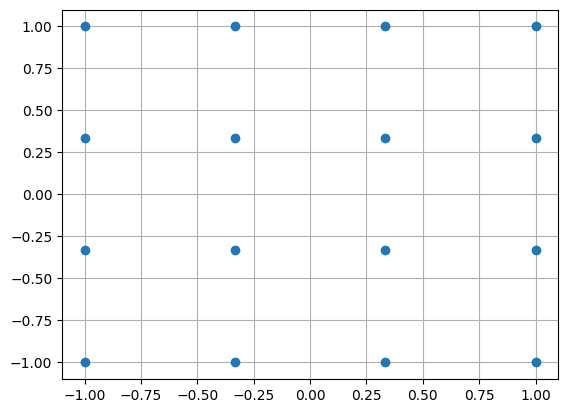

In [399]:
plt.plot(qam16_arr.real,qam16_arr.imag,'o')
plt.grid()
plt.show()

In [400]:
nibbles = bytes_to_nibbles(message)

print(nibbles)

[4, 3, 5, 3, 9, 4, 6, 9, 13, 0, 1, 6, 0, 8, 0, 11, 11, 15, 7, 10, 2, 15, 13, 0, 1, 7, 13, 9, 2, 11, 1, 1, 9, 8, 8, 0, 13, 5, 13, 3, 13, 12, 8, 11, 5, 13, 4, 7, 13, 7, 0, 4, 12, 7, 0, 8, 10, 11, 9, 9, 1, 12, 10, 10, 14, 11, 5, 10, 13, 11, 3, 7, 14, 7, 12, 0, 9, 15, 8, 2, 14, 6, 7, 2, 4, 7, 8, 11, 6, 6, 0, 2, 2, 7, 9, 6, 7, 15, 10, 8, 5, 8, 13, 4, 10, 1, 10, 9, 3, 3, 0, 5, 2, 15, 10, 1, 4, 14, 9, 10, 6, 2, 9, 5, 14, 0, 0, 11]


In [401]:
def extend(syms,n):
    result = []
    for s in syms:
        for i in range(n):
            result.append(s)

    return np.array(result,dtype=np.uint8)

In [402]:
symbols = extend(nibbles,10)
print(symbols)

[ 4  4  4 ... 11 11 11]


In [403]:
rf_data = np.zeros((1,len(symbols)),dtype=np.complex64)

for i in range(len(symbols)):
    rf_data[0][i] = qam16[symbols[i]]
    

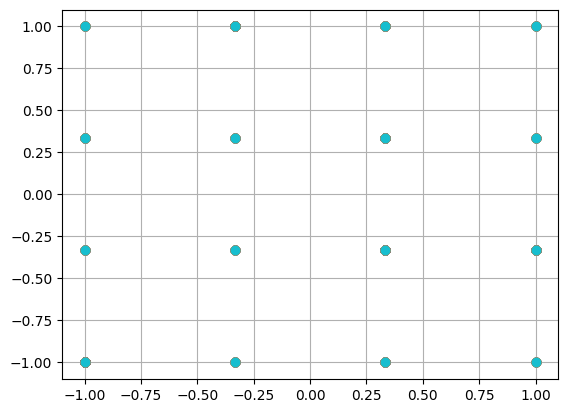

In [404]:
plt.plot(rf_data.real,rf_data.imag,'o')
plt.grid()
plt.show()

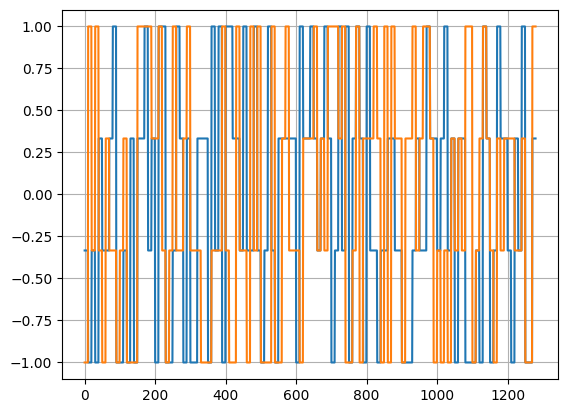

1280


In [405]:
plt.plot(rf_data[0].real)
plt.plot(rf_data[0].imag)
plt.grid()
plt.show()  
print(len(rf_data[0]))

In [406]:
# noise + channel
noise = np.random.normal(0,0.1,len(rf_data[0]))

In [407]:
def change_dynamic_range(s, in_min, in_max, out_min, out_max):
    return np.round((s - in_min) / (in_max - in_min) * (out_max - out_min) + out_min)



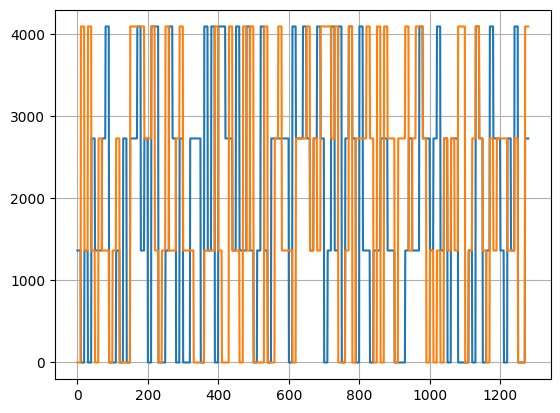

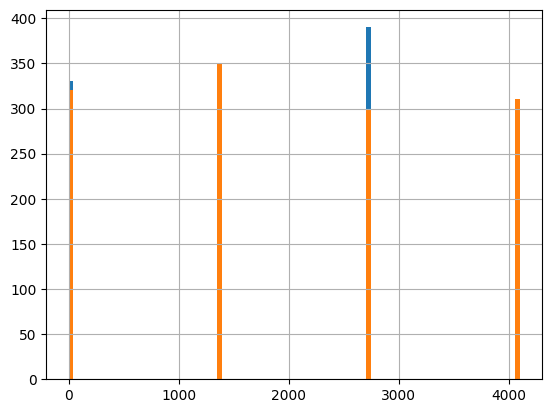

[1365.0, 0.0, 2731.0, 4096.0]


In [408]:
rf_12_bits_real = change_dynamic_range(rf_data[0].real, -1, 1, 0, 1<<12)
rf_12_bits_imag = change_dynamic_range(rf_data[0].imag, -1, 1, 0, 1<<12)
rf_12_bits = rf_12_bits_real + 1j*rf_12_bits_imag
plt.plot(rf_12_bits.real)
plt.plot(rf_12_bits.imag)
plt.grid()
plt.show()
plt.hist(rf_12_bits_real,bins=100)
plt.hist(rf_12_bits_imag,bins=100)
plt.grid()
plt.show()
bins = []
for bin in rf_12_bits_real:
    
    if bin not in bins:
        bins.append(bin)
        
print(bins)
    

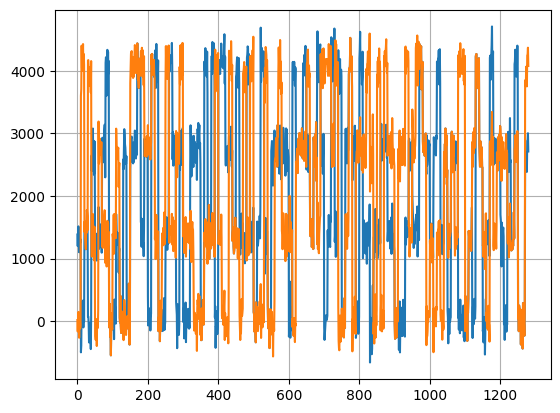

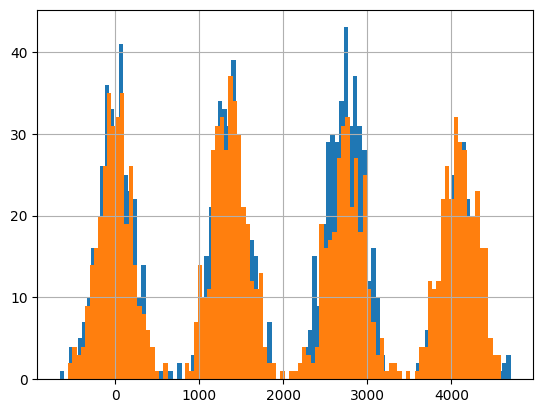

In [ ]:
rf_noisy_real = rf_data[0].real + noise
rf_noisy_imag = rf_data[0].imag + noise
rf_noisy = rf_noisy_real + 1j*rf_noisy_imag
rf_12_bits_real_noisy = change_dynamic_range(rf_noisy_real, -1, 1, 0, 1<<12)
rf_12_bits_imag_noisy = change_dynamic_range(rf_noisy_imag, -1, 1, 0, 1<<12)
rf_12_bits_noisy = rf_12_bits_real_noisy + 1j*rf_12_bits_imag_noisy



plt.plot(rf_12_bits_noisy.real)
plt.plot(rf_12_bits_noisy.imag)
plt.grid()
plt.show()
plt.hist(rf_12_bits_noisy.real,bins=100)
plt.hist(rf_12_bits_noisy.imag,bins=100)
plt.grid()
plt.show()

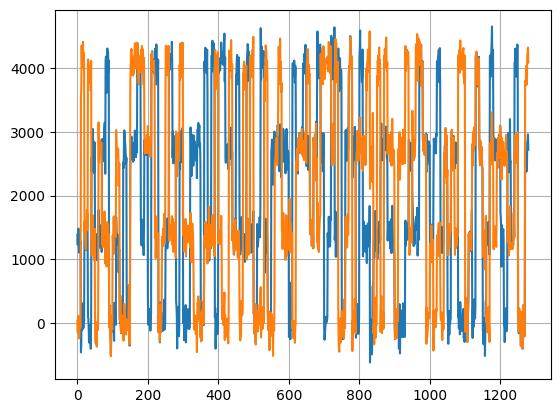

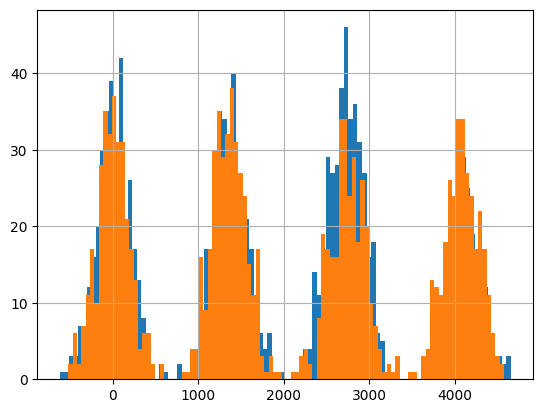

In [410]:
received = change_dynamic_range(rf_12_bits_noisy, 0, 1<<12, -1, 1)
# type(received)

def denoise(s):
    coeffs = pywt.wavedec(s,'db6',level=4)
    new_coeffs = coeffs.copy()
    thr=25
    method = 'soft'
    new_coeffs[0] = pywt.threshold(coeffs[0],thr,method)
    new_coeffs[1] = pywt.threshold(coeffs[1],thr,method)
    new_coeffs[2] = pywt.threshold(coeffs[2],thr,method)
    new_coeffs[3] = pywt.threshold(coeffs[3],thr,method)
    new_coeffs[4] = pywt.threshold(coeffs[4],thr,method)
    return pywt.waverec(new_coeffs,'db6')

received_real_dn = denoise(rf_12_bits_noisy.real) 
received_imag_dn = denoise(rf_12_bits_noisy.imag)
received_dn = received_real_dn + 1j*received_imag_dn
plt.plot(received_dn.real)
plt.plot(received_dn.imag)
plt.grid()
plt.show()
plt.hist(received_dn.real,bins=100)
plt.hist(received_dn.imag,bins=100)
plt.grid()
plt.show()

In [414]:
with open("signals.npy","wb") as f:
    np.save(f,rf_data)
    np.save(f,rf_12_bits)
    np.save(f,rf_noisy)
    np.save(f,rf_12_bits_noisy)
    np.save(f,received_dn)

In [411]:
rec_dn = change_dynamic_range(received_dn, 0, 1<<12, -1, 1)
recovered = [QAM_demodulate(s,qam16) for s in rec_dn]
print(recovered[::10])
print(nibbles)

[5, 3, 7, 3, 7, 5, 7, 7, 15, 1, 3, 7, 1, 5, 1, 7, 7, 15, 7, 7, 3, 15, 15, 1, 3, 7, 15, 7, 3, 7, 3, 3, 7, 5, 5, 1, 15, 7, 15, 3, 15, 13, 5, 7, 7, 15, 5, 7, 13, 7, 1, 5, 13, 7, 1, 5, 7, 7, 7, 5, 3, 13, 7, 7, 15, 7, 7, 7, 15, 7, 3, 7, 15, 7, 13, 1, 7, 15, 5, 3, 15, 7, 7, 3, 5, 7, 5, 7, 7, 7, 1, 3, 3, 7, 7, 7, 7, 15, 7, 5, 7, 5, 15, 5, 7, 3, 7, 7, 3, 3, 1, 7, 3, 15, 7, 3, 5, 15, 7, 7, 7, 3, 7, 7, 15, 1, 1, 7]
[4, 3, 5, 3, 9, 4, 6, 9, 13, 0, 1, 6, 0, 8, 0, 11, 11, 15, 7, 10, 2, 15, 13, 0, 1, 7, 13, 9, 2, 11, 1, 1, 9, 8, 8, 0, 13, 5, 13, 3, 13, 12, 8, 11, 5, 13, 4, 7, 13, 7, 0, 4, 12, 7, 0, 8, 10, 11, 9, 9, 1, 12, 10, 10, 14, 11, 5, 10, 13, 11, 3, 7, 14, 7, 12, 0, 9, 15, 8, 2, 14, 6, 7, 2, 4, 7, 8, 11, 6, 6, 0, 2, 2, 7, 9, 6, 7, 15, 10, 8, 5, 8, 13, 4, 10, 1, 10, 9, 3, 3, 0, 5, 2, 15, 10, 1, 4, 14, 9, 10, 6, 2, 9, 5, 14, 0, 0, 11]


In [413]:
from sklearn.cluster import KMeans

ModuleNotFoundError: No module named 'sklearn'

[67, 83, 148, 105, 208, 22, 8, 11, 191, 122, 47, 208, 23, 217, 43, 17, 152, 128, 213, 211, 220, 139, 93, 71, 215, 4, 199, 8, 171, 153, 28, 170, 235, 90, 219, 55, 231, 192, 159, 130, 230, 114, 71, 139, 102, 2, 39, 150, 127, 168, 88, 212, 161, 169, 51, 5, 47, 161, 78, 154, 98, 149, 224, 11]
[ 67  83 148 105 208  22   8  11 191 122  47 208  23 217  43  17 152 128
 213 211 220 139  93  71 215   4 199   8 171 153  28 170 235  90 219  55
 231 192 159 130 230 114  71 139 102   2  39 150 127 168  88 212 161 169
  51   5  47 161  78 154  98 149 224  11]


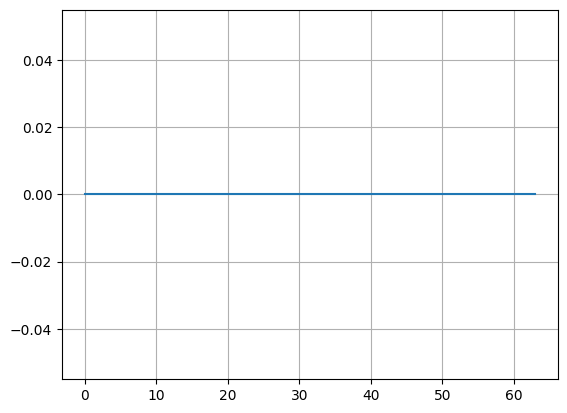

In [412]:
bytes = nibbles_to_bytes(nibbles)
print(bytes)
print(message)
difference = [int(b)-int(m) for b,m in zip(bytes,message)]
# plt.plot(message,label='message')
# plt.plot(bytes[0],label='bytes')
# plt.legend()
# plt.grid()
# plt.show()
plt.plot(difference)
plt.grid()
plt.show()